Loading crops...:   0%|          | 0/1315 [00:00<?, ?it/s]

torch.Size([1, 128, 128])
torch.bool


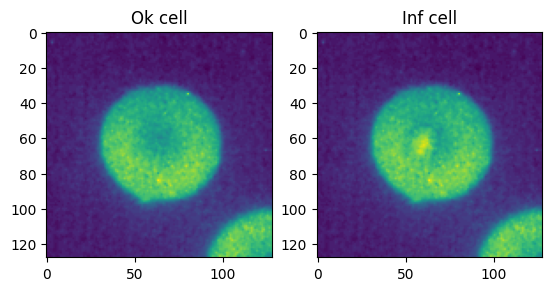

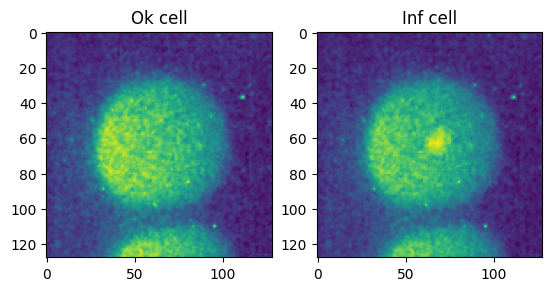

torch.Size([506])
torch.Size([502])
0.0261**2 * RBF(length_scale=0.515)
GP On train set:  1.0
GP On test set:  0.5
RF On train set:  1.0
RF On test set:  0.9362549800796812


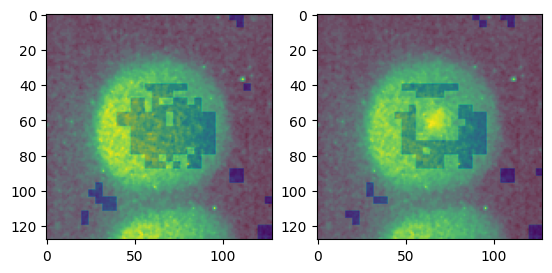

In [26]:
from this_experiment.models import CPFeatures
from this_experiment.dataset import CellCrops
from this_experiment.transforms import add_ellipse_random_placement

from pathlib import Path
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import torch

import matplotlib.pyplot as plt

DSET_PATH = Path("/data/dataset/fl_dataset/healthy_train/raw")
dset = CellCrops(DSET_PATH, transforms=None, ext=None, load_to_gpu=None, set_size=128, debug=False)

cp = CPFeatures([2, 32, 64, 128, 256], 3, 3, diam_mean=70, pretrained_path="/model/cyto2torch_0")
#outp_ = cp((dset[0] / 255.)[None,].expand(-1,2,-1,-1))[0]
#print(outp_.shape)

img = dset[0]
img, mask = add_ellipse_random_placement(img, (60,70), (60,70), (10,20), (5,10), (0, 1.6))
print(img.shape)
print(mask.dtype)

def subsample(X, m):
    r"""
    Inputs:

        :X: (N_samples, N_features)

        :m: int

    Returns:
        (m, N_features)
    """
    N_samples = X.shape[0]
    sample_idxs = (torch.rand(m) * N_samples).floor().long()

    return X[sample_idxs]

def test_classifier_forward():
    r"""
    """
    
    cp_transform = lambda img : cp((img / img.max())[None,].expand(-1,2,-1,-1))[0]

    def get_good_bad(img):
        r"""
        Ret X,y balanced dataset.
        """

        img_bad, mask_bad = add_ellipse_random_placement(img, (60,70), (60,70), (10,15), (5,10), (0, 1.6),
                                                        scale=100.)
        feats_bad = cp_transform(img_bad)[:,mask_bad].T
        feats_ok =  cp_transform(img)[:,mask_bad].T
        #feats_ok = subsample(cp_transform(img).flatten(start_dim=1).T, len(feats_bad))
        
        fig, axes = plt.subplots(1,2)
        axes[0].imshow(img[0] / img[0].max()); axes[0].set_title("Ok cell")
        axes[1].imshow(img_bad[0] / img_bad[0].max()); axes[1].set_title("Inf cell")
        plt.show()

        X = torch.cat([feats_ok, feats_bad], dim=0)
        y = torch.cat([torch.zeros(feats_ok.shape[0]),
                             torch.ones(feats_bad.shape[0])
                             ]).int()

        return X, y

    img_ok = dset[1]
    X_train, y_train = get_good_bad(img_ok)
    
    img_ok_test = dset[3]
    X_test, y_test = get_good_bad(img_ok_test)
    print(y_train.shape)
    print(y_test.shape)

    gp_clf = GaussianProcessClassifier(                    
                    ConstantKernel(1.0) * \
                    RBF(length_scale=5.0)
    )
    gp_clf.fit(X_train, y_train)
    print(gp_clf.kernel_)
    print("GP On train set: ", gp_clf.score(X_train, y_train))
    print("GP On test set: ", gp_clf.score(X_test, y_test))
    
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    print("RF On train set: ", rf_clf.score(X_train, y_train))
    print("RF On test set: ", rf_clf.score(X_test, y_test))
    
    fig, axes = plt.subplots(1,2)
    inp_ = cp_transform(dset[3])
    img_bad, _ = add_ellipse_random_placement(dset[3], (60,70), (60,70), (10,15), (5,10), (0, 1.6),
                                            scale=100.)
    inp_bad_ = cp_transform(img_bad)
    C, H, W = inp_.shape
    outp_viz = rf_clf.predict(inp_.flatten(start_dim=1).T).reshape(H,W)
    outp_viz_bad = rf_clf.predict(inp_bad_.flatten(start_dim=1).T).reshape(H,W)
    axes[0].imshow(outp_viz)
    axes[0].imshow(dset[3][0], alpha=0.8)
    axes[1].imshow(outp_viz_bad)
    axes[1].imshow(img_bad[0], alpha=0.8)

test_classifier_forward()


In [16]:
n_total = 1000
n_eval = 50

X, y = make_classification(random_state=1, 
                           n_samples=n_total, 
                           n_informative=2, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=1,
                           n_features=2)

X_tr, y_tr = X[:-n_eval], y[:-n_eval]
X_ev, y_ev = X[-n_eval:], y[-n_eval:]

print("X_tr : {}".format(X_tr.shape))
print("X_ev : {}".format(X_ev.shape))

clf = GaussianProcessClassifier(
        kernel=(
                    ConstantKernel(1.0) * \
                    RBF(length_scale=1.0)
        )
)

clf.fit(X_tr, y_tr)
clf.score(X_ev, y_ev)

print(clf.kernel_)

X_tr : (950, 2)
X_ev : (50, 2)
6.4**2 * RBF(length_scale=1.33)


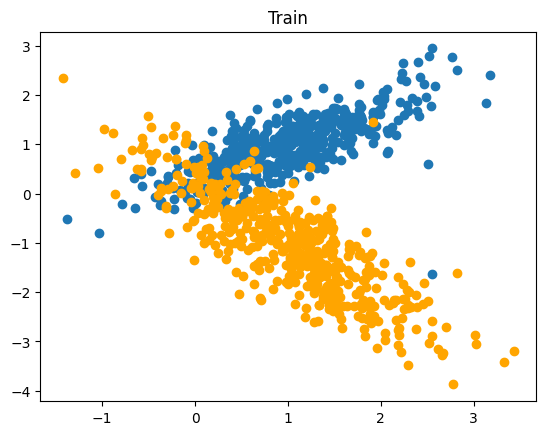

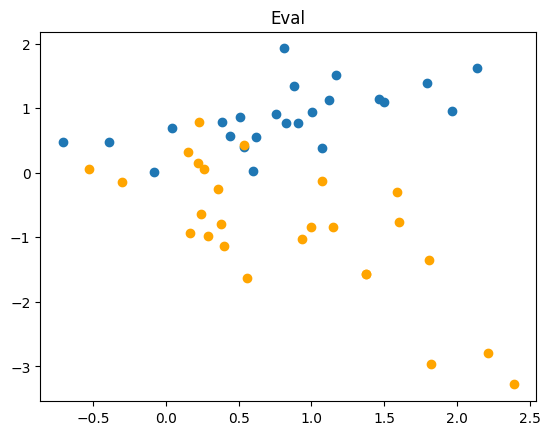

In [17]:
def viz_xy(X, y, title=None):
    plt.scatter(X[y==0][:,0], X[y==0][:,1])
    plt.scatter(X[y==1][:,0], X[y==1][:,1], color='orange')
    plt.title(title)
    plt.show()
    
viz_xy(X_tr, y_tr, title="Train")
viz_xy(X_ev, y_ev, title="Eval")